In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [41]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

- We will use a **Tf.data.dataset** - a datastructure that u use to transform large dataset in to batches of smaller dstaset
- Important link here - *https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory*

In [3]:
IMAGE_SIZE = 256 # size of the potatoe images
BATCH_SIZE= 32 # A standard batch size
CHANNELS = 3 #RGB

In [4]:
# Generates a tf.data.Dataset from image files in a directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# Your folder names are class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

- We can see on top that the length of the dataset is **68**. If we multiply **68** by **32** we get **2176**. The batch size is smaller than the actual size which is **2152** **:)**
- Hence one batch is 32 images!

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 2 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1]


- From the above printing image_batch, there are 32 images, each 256 by 256 and having 3 channels (RGB)
- From the label_batch, 0,1 and 2 identify the 3 classes of potatoes.

In [8]:
# print first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
  

[[[127. 121. 131.]
  [126. 120. 130.]
  [127. 121. 131.]
  ...
  [180. 178. 189.]
  [179. 177. 188.]
  [178. 176. 187.]]

 [[126. 120. 130.]
  [127. 121. 131.]
  [129. 123. 133.]
  ...
  [175. 173. 184.]
  [174. 172. 183.]
  [173. 171. 182.]]

 [[120. 114. 124.]
  [123. 117. 127.]
  [127. 121. 131.]
  ...
  [179. 177. 188.]
  [178. 176. 187.]
  [178. 176. 187.]]

 ...

 [[145. 142. 153.]
  [137. 134. 145.]
  [136. 133. 144.]
  ...
  [183. 181. 192.]
  [184. 182. 193.]
  [185. 183. 194.]]

 [[141. 138. 149.]
  [144. 141. 152.]
  [140. 137. 148.]
  ...
  [183. 181. 192.]
  [183. 181. 192.]
  [183. 181. 192.]]

 [[131. 128. 139.]
  [146. 143. 154.]
  [146. 143. 154.]
  ...
  [186. 184. 195.]
  [186. 184. 195.]
  [185. 183. 194.]]]


In [9]:
# What is the shape of the first image

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
  

(256, 256, 3)


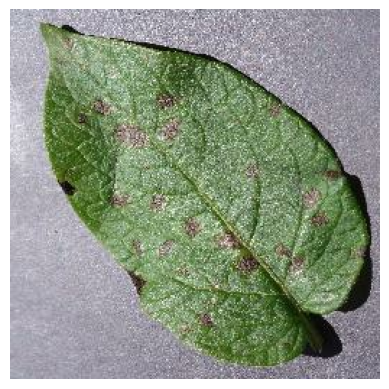

In [10]:
# Print the first image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

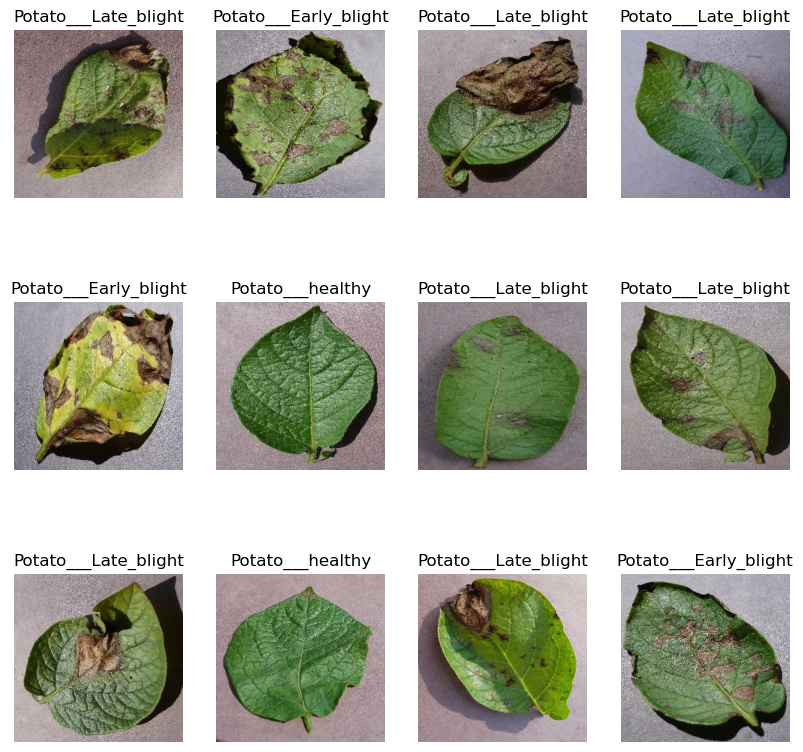

In [11]:
# Print the first image
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Function to split Dataset

Dataset should be bifurcated into 3 subsets, namely:

1) Training: Dataset to be used while training
2) Validation: Dataset to be tested against while training
3) Test: Dataset to be tested against after we trained a model

- Split into training and test set

80% ==> training
20% == > 10% validation, 10% test

- We use the training set to train our model, every 50 Epoch(iteration) we do the validation. And then we use the 10% test set to test the performance of our model before we deploy

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
# Take the first 54 samples (which are 80% of the dataset)
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
len(dataset) * 0.1

6.800000000000001

In [15]:
remaining_ds = dataset.skip(54)
len(remaining_ds)

14

In [16]:
val_size = 0.1
validation_ds = remaining_ds.take(6)
len(validation_ds)

6

In [17]:
test_ds = remaining_ds.skip(6)
len(test_ds)

8

- PUT IN ALL OF THESE INTO ONE FUNCTIONS

In [18]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    val_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
    

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

### Cache, Shuffle and prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


- prefetch and cache improves performance. prefetch does this by preloading the data in the cpu while GPU is training the data during the iterations (epoche), Cache also saves time while reading the images

## Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data augmentation

- Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

**Watch below video if you are not familiar with data augmentation**
https://www.youtube.com/embed/mTVf7BN7S8w

In [24]:
# ADD DATA AUGMENTATION LAYER

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture

- Now, we are going to build the model. first, we will resize and rescale the image, and then we will do data augmentation (vertical and horizontal random flipping, and finally we will add a convolutional layer and then relu and poolin layers and output layer too
- We use a CNN couples with a **Softmax activation** in the output layer. We also add the initial layers for **resizing, normalization and Data Augmentation**.

We need to know the arguments for convolutional layer, so we go here - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- The kernes_size below determines the filter.
- We are going to have 32 layers in this case - for instance: image's edge and so on. The neural network figures that out for you and it is a trial and error thing.

In [25]:
""" tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
) """

" tf.keras.layers.Conv2D(\n    filters,\n    kernel_size,\n    strides=(1, 1),\n    padding='valid',\n    data_format=None,\n    dilation_rate=(1, 1),\n    groups=1,\n    activation=None,\n    use_bias=True,\n    kernel_initializer='glorot_uniform',\n    bias_initializer='zeros',\n    kernel_regularizer=None,\n    bias_regularizer=None,\n    activity_regularizer=None,\n    kernel_constraint=None,\n    bias_constraint=None,\n    **kwargs\n) "

In [26]:
# Building the model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
EPOCHS = 2
model = models.Sequential ([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)    
    

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

### Compiling the Model

We use adam **Optimizer**, SparseCategoricalCrossentropy for **losses**, accuracy as a **metric**

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs = 2,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/2
54/54 [==============================] - 547s 5s/step - loss: 0.9091 - accuracy: 0.4878 - val_loss: 0.8327 - val_accuracy: 0.5208
Epoch 2/2
54/54 [==============================] - 206s 4s/step - loss: 0.7186 - accuracy: 0.6626 - val_loss: 0.5326 - val_accuracy: 0.8125


- As epochs increase, the validation accuracy is seen to increase

- We should try the model on a new dataset - the test dataset - this is something the model has not seen before

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 760ms/step - loss: 0.5164 - accuracy: 0.8190


In [31]:
scores

[0.5164005160331726, 0.818965494632721]

- The first parameter in the above is loss, the second is accuracy

In [32]:
history

In [33]:
history.params


{'verbose': 1, 'epochs': 2, 'steps': 54}

- history has some parameteres - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.4878472089767456, 0.6626157164573669]

- We have two accuracy in this case because I only ran 2 epochs.

In [36]:
len(history.history['accuracy'])

2

- We can plot these accuracy in matplotlib chart

### validation accuracy and training accuracy graph VS EPOCHS

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


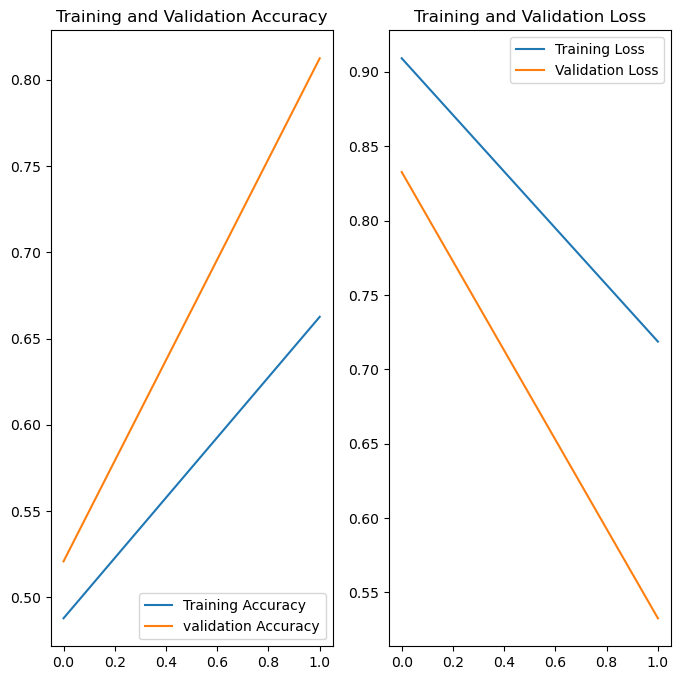

In [38]:
EPOCHS = 2
plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Loss graph

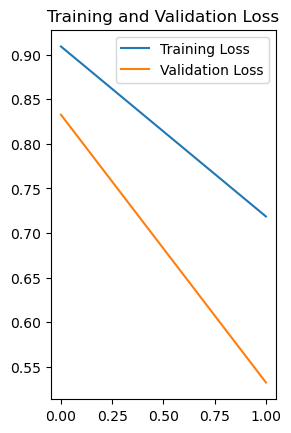

In [39]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- As the number of epochs increase the training and validation accuracy increases

In [45]:
for images_batch, lables_batch in test_ds.take(1):
    print(images_batch[0])

tf.Tensor(
[[[105.  77.  76.]
  [151. 123. 122.]
  [116.  88.  87.]
  ...
  [213. 195. 195.]
  [198. 180. 180.]
  [191. 173. 173.]]

 [[151. 123. 122.]
  [140. 112. 111.]
  [180. 152. 151.]
  ...
  [196. 178. 178.]
  [187. 169. 169.]
  [186. 168. 168.]]

 [[138. 110. 109.]
  [127.  99.  98.]
  [100.  72.  71.]
  ...
  [187. 169. 169.]
  [201. 183. 183.]
  [206. 188. 188.]]

 ...

 [[110.  86.  86.]
  [127. 103. 103.]
  [135. 111. 111.]
  ...
  [174. 156. 156.]
  [155. 137. 137.]
  [177. 159. 159.]]

 [[125. 101. 101.]
  [125. 101. 101.]
  [115.  91.  91.]
  ...
  [161. 143. 143.]
  [153. 135. 135.]
  [166. 148. 148.]]

 [[115.  91.  91.]
  [156. 132. 132.]
  [128. 104. 104.]
  ...
  [139. 121. 121.]
  [172. 154. 154.]
  [142. 124. 124.]]], shape=(256, 256, 3), dtype=float32)


- The above image is a tensor - we can convert to numpy arrays (Three dimensional array)

In [46]:
for images_batch, lables_batch in test_ds.take(1):
    print(images_batch[0].numpy())

[[[115. 109. 119.]
  [173. 167. 177.]
  [199. 193. 203.]
  ...
  [173. 170. 179.]
  [176. 173. 182.]
  [178. 175. 184.]]

 [[152. 146. 156.]
  [128. 122. 132.]
  [156. 150. 160.]
  ...
  [174. 171. 180.]
  [174. 171. 180.]
  [175. 172. 181.]]

 [[146. 140. 150.]
  [110. 104. 114.]
  [126. 120. 130.]
  ...
  [173. 170. 179.]
  [173. 170. 179.]
  [173. 170. 179.]]

 ...

 [[147. 144. 155.]
  [125. 122. 133.]
  [122. 119. 130.]
  ...
  [155. 152. 163.]
  [152. 149. 160.]
  [149. 146. 157.]]

 [[153. 150. 161.]
  [159. 156. 167.]
  [ 96.  93. 104.]
  ...
  [166. 163. 174.]
  [159. 156. 167.]
  [159. 156. 167.]]

 [[115. 112. 123.]
  [124. 121. 132.]
  [ 80.  77.  88.]
  ...
  [160. 157. 168.]
  [157. 154. 165.]
  [165. 162. 173.]]]


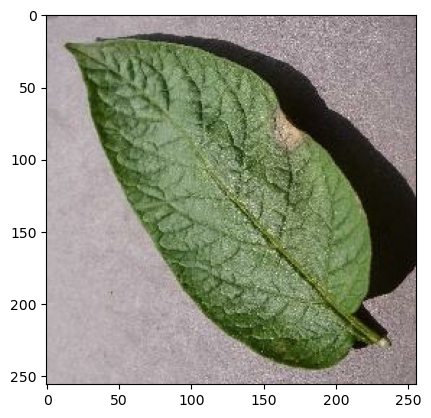

In [55]:
# I want to display the actual image

for images_batch, lables_batch in test_ds.take(1):
    plt.imshow(images_batch[1].numpy().astype('uint8'))

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 1s 968ms/step
[6.7419434e-01 3.2527357e-01 5.3201715e-04]
predicted label:  Potato___Early_blight


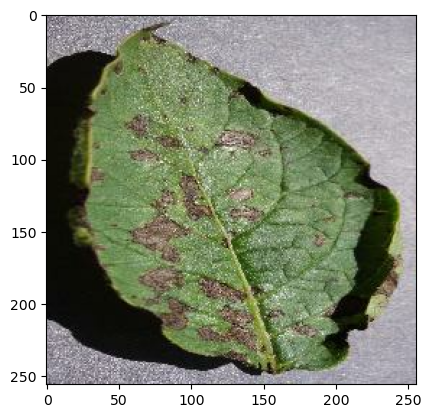

In [64]:
for images_batch, lables_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = lables_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    # Now I want to find the predicted label
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    # We can use argmax to identify the highest
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])
    


- As we can see from the above the prediction, it is a three dimensional array. This is because in our model architecture, we have three neurons and we are using softmax as an activation (softmax is just a probablity).

- What ever is the highest probablity, that is the class.

In [ ]:
### Write a function for inference


In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


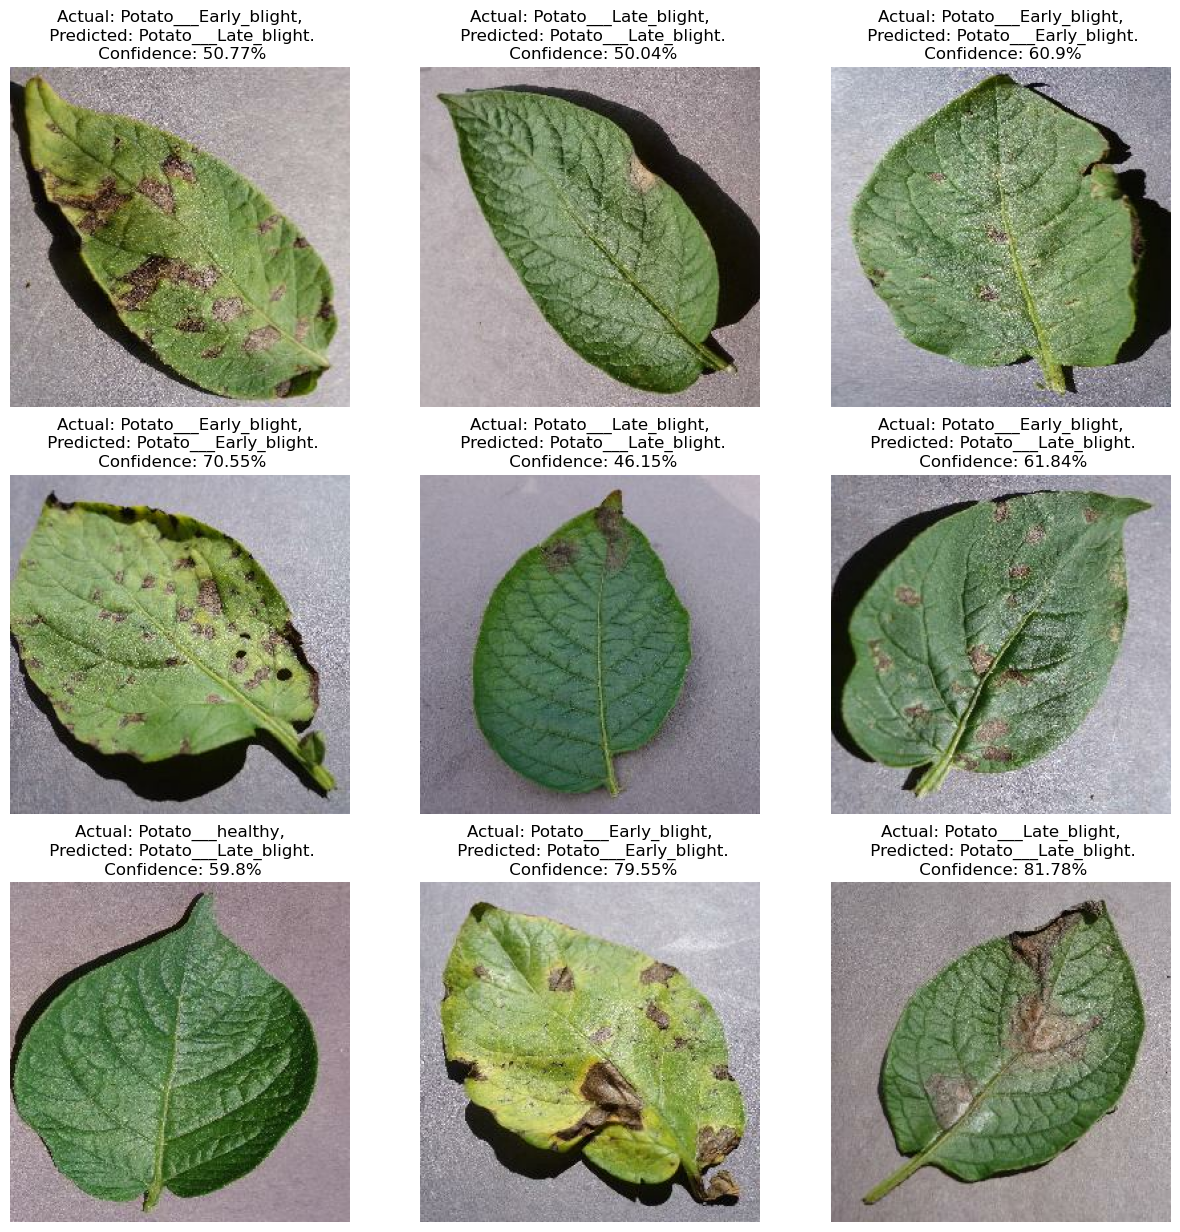

In [67]:
# let us do predictions in the first 9 images

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [70]:
model_version = 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


- You can try out different model versions. 1) by changing data augmentation 2) changing model architecture 3) changing optimizer